<a href="https://colab.research.google.com/github/yohanesnuwara/pyreservoir/blob/master/notebooks/volumetrics_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!git clone https://www.github.com/yohanesnuwara/pyreservoir

Cloning into 'pyreservoir'...
remote: Enumerating objects: 219, done.
remote: Counting objects: 100% (219/219), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 219 (delta 112), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (219/219), 77.75 KiB | 5.18 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [ ]:
import sys
sys.path.append('/content/pyreservoir/volumetrics')

In [ ]:
from volumetrics import get_contours, compute_area, trapezoid, pyramidal, simpson

In [ ]:
# load data
welldat = pd.read_csv('/content/pyreservoir/data/volumetric_data.csv')
x, y, z, h, poro, sw = welldat.x, welldat.y, welldat.depth, welldat.h, welldat.poro, welldat.sw


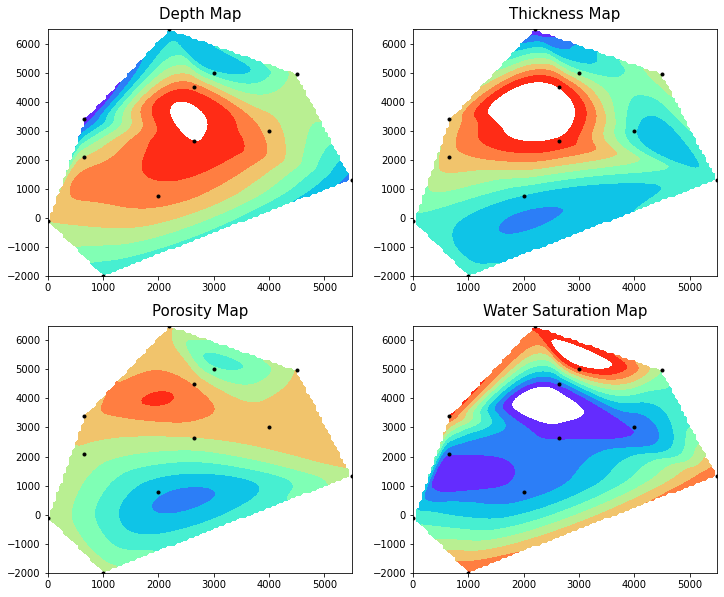

In [ ]:
# plot contour map of OIP from the resulted N data"
from scipy.interpolate import griddata
import matplotlib.cm as cm

# define the z values for plotting
z = np.array([[z, h],
              [poro, sw]])

# grid x and y coordinate data
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# define subplots and colormap
figs, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

# define each subplot title
title = np.array([['Depth Map', 'Thickness Map'],
                  ['Porosity Map', 'Water Saturation Map']])

for i in range(2):
  for j in range(2):
    zi = griddata((x,y), z[i,j], (xi,yi), method='cubic')
    levels = np.linspace(min(z[i,j])-0.1, max(z[i,j])+0.1, 10)
    ax[i,j].contourf(xi, yi, zi, levels=levels, cmap='rainbow')  
    ax[i,j].plot(x, y, 'ko', ms=3) # plot the well points
    ax[i,j].set_title(title[i,j], pad=10, size=15)
    

In [ ]:
# known
Bo = 1.435 # in RB/STB
owc = -4960 # oil water contact, in ft

N = welldat.h * welldat.poro * (1 - welldat.sw) / Bo
N = N * (1 / 5.61458) # convert the result from ft3/ft2 to standard STB/ft2
df = pd.DataFrame({"well_id": welldat.well_id, "N (STB/ft2)": N})
df = pd.merge(welldat, df, on='well_id')

# display result of OIP per ft2 calculation
df


,well_id,x,y,depth,h,poro,sw,N (STB/ft2)
0,1,0.0,-110.0,-4900,25,0.200,0.50,0.310292
1,2,4500.0,4970.0,-4920,33,0.205,0.65,0.293878
2,3,2640.0,2640.0,-4800,44,0.200,0.20,0.873783
3,4,660.0,2100.0,-4900,36,0.190,0.22,0.662188
4,5,2000.0,770.0,-4850,22,0.023,0.27,0.045846
5,6,2640.0,4500.0,-4850,45,0.242,0.23,1.040757
6,7,4000.0,3000.0,-4880,23,0.235,0.22,0.523264
7,8,660.0,3400.0,-5100,34,0.230,1.00,0.000000
8,9,5500.0,1320.0,-5050,24,0.190,1.00,0.000000
9,10,2200.0,6500.0,-5010,11,0.210,1.00,0.000000


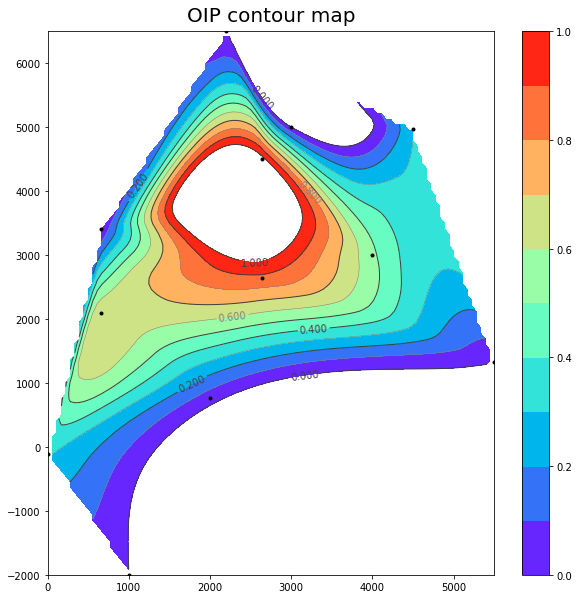

In [ ]:
# plot contour map of OIP from the resulted N data"
from scipy.interpolate import griddata

# define z value for plotting as: N (OIP per area)
z = N 

# grid N data with cubic interpolation method
zi = griddata((x,y),z,(xi,yi),method='cubic')

levels = np.arange(0, 1.1, 0.1)

# plot OIP per area
plt.figure(figsize=(10, 10))
figs = plt.contour(xi, yi, zi, levels=levels, colors=['0.25', '0.5', '0.25', '0.5', '0.25'], linewidths=[1.0, 0.5, 1, 0.5, 1])
plt.contourf(xi,yi,zi,levels=levels, cmap="rainbow")
plt.plot(x, y, 'ko', ms=3) # plot the well points
plt.clabel(figs, figs.levels[::2], inline=1, fontsize=10) # give labels for contours
plt.title("OIP contour map", pad=10, size=20)
plt.colorbar()
plt.show()


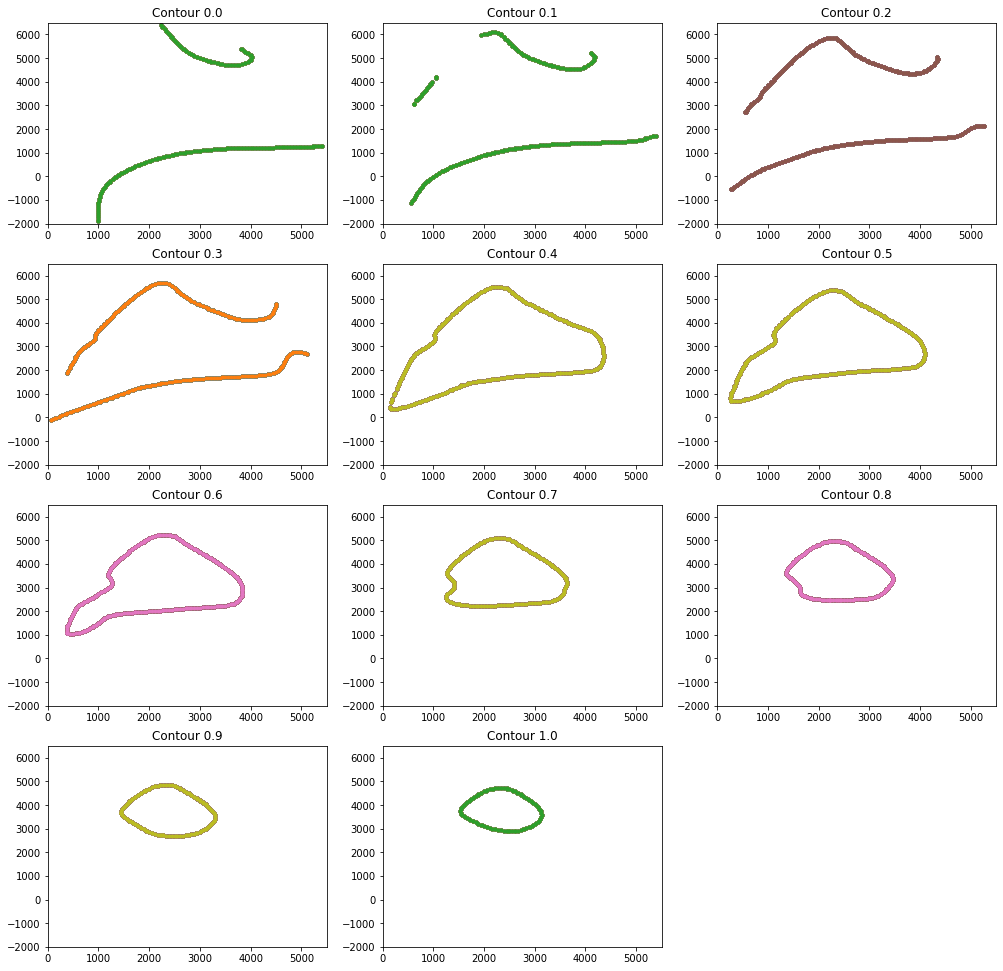

In [ ]:
# get the individual contour lines and plot
contour_all = get_contours(figs, xi, yi, plot='Yes')

In [ ]:
contour_area = compute_area(contour_all)

areas = pd.DataFrame({"OIP Contour(STB)": levels, "Area(ft2)": contour_area})
areas

,OIP Contour(STB),Area(ft2)
0,0.0,1.761776e+07
1,0.1,7.834510e+06
2,0.2,1.000735e+07
3,0.3,8.209183e+06
4,0.4,1.105959e+07
5,0.5,9.068078e+06
6,0.6,7.225491e+06
7,0.7,5.017789e+06
8,0.8,3.771974e+06
9,0.9,2.801986e+06


In [ ]:
oip_trapezo = trapezoid(contour_area, 0.1)
oip_pyramidal = pyramidal(contour_area, 0.1)
oip_simpson = simpson(contour_area, 0.1)


print("Oil in Place using Trapezoidal Method:", np.round((oip_trapezo / 1E+06), 3), "million STB")
print("Oil in Place using Pyramidal Method:", np.round((oip_pyramidal / 1E+06), 3), "million STB")
print("Oil in Place using Simpson 1/3 Method:", np.round((oip_simpson / 1E+06), 3), "million STB")


Oil in Place using Trapezoidal Method: 7.484 million STB
Oil in Place using Pyramidal Method: 7.434 million STB
Oil in Place using Simpson 1/3 Method: 7.185 million STB
